# Beth Hilbert ~ Expedia Dataset ~ Data Exploration

The dataset is part of a Kaggle Competition sponsored by Expedia. In this notebook, the dataset is explored for meaningful patterns using statistical analysis, graphical, and numeric summaries. This is part 1 of my final project for the University of Cincinnati class "Analytics Using Python." See the other notebook (part 2) for the Data Analytics Models used.



## 1. Business Understanding

 

Expedia is a travel company booking website that is seeking to improve their algorithms used to suggest hotels. In order to accomplish this, they have created 100 clusters of similar hotels based on hotel popularity, rating, user review rating, price, distance from city center, and amenities. The goal of the Kaggle Competition is to predict which hotel cluster an Expedia user will book, based on their searching attributes and hotel information. Expedia has provided a dataset of customer searches, some of which includes what they searched for (number rooms, number people, dates, location), location where they the search from (site, channel, country where they initiated search), and the result (clicks and whether it resulted in a booking). 

## 2. Data Understanding

### Acquiring the Dataset From Kaggle

Expedia gave Kaggle three csv files (destination, train, and test). Destinations contains info about regions users searched in for hotels. Train and test are split based on year. Training data is from 2013/2014 and includes the clicks and books. Testing data is from 2015 and only includes booking events. For this reason, I selected training data. I downloaded the dataset from Kaggle - https://www.kaggle.com/c/expedia-hotel-recommendations and unzipped it using 7-Zip. 
These are the column names and descriptions as given by Kaggle:


### Import Modules

First I imported modules and assigned some of them an alias.

In [1]:
""" Import modules and set up plotting. """

import collections
import datetime
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl
import scipy
import seaborn as sb
import sklearn
import statsmodels.formula.api as smf
import statsmodels.api as sm

from pandas import Series, DataFrame
from pandas.tools.plotting import scatter_matrix
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

# Plotting Graphs Configuration
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 14, 7
plt.style.use('seaborn-whitegrid')


### Read Data Into the iPython Notebook

Using Pandas, I read the the data from the 'train.csv' file. I modified the data by converting some columns to boolean, some to dates, and adding columns for length of stay and number of people. Following this, I displayed the shape, column names/types, and header of the first 5 rows. 

In [2]:
""" Read data from the train.csv file using pandas."""

train = pd.read_csv("train.csv", nrows=1000)

In [3]:
""" Column Modifications, including converting (to boolean and date time) and adding a few calculated columns. """

# Converts subset of columns to boolean
train[['is_mobile', 'is_package', 'is_booking']] = train[['is_mobile', 'is_package', 'is_booking']].astype(np.bool)

# Converts subset of columns to dates
train['date_time'] = pd.to_datetime(train['date_time'], errors='coerce', yearfirst=True)
train['year'] = train['date_time'].dt.year
train['month'] = train['date_time'].dt.month
train['srch_co'] = pd.to_datetime(train['srch_co'], errors='coerce', yearfirst=True)
train['srch_ci'] = pd.to_datetime(train['srch_ci'], errors='coerce', yearfirst=True)

# Adds column for length of stay
srch_length_of_stay = train['srch_co'] - train['srch_ci']
train['srch_length_of_stay'] = srch_length_of_stay

# Adds column for number of people
srch_people_cnt = train['srch_adults_cnt'] + train['srch_children_cnt']
train['srch_people_cnt'] = srch_people_cnt

In [4]:
""" Data shape, column names/types, and header which displays a snapshot of the data. """

print
print "shape (rows, columns): " + str(train.shape)
print
print "data column name:\tdata type:"
print train.dtypes
print
print "Dataset:: ", str(train)
print
print "Header:"
train.head()


shape (rows, columns): (1000, 28)

data column name:	data type:
date_time                     datetime64[ns]
site_name                              int64
posa_continent                         int64
user_location_country                  int64
user_location_region                   int64
user_location_city                     int64
orig_destination_distance            float64
user_id                                int64
is_mobile                               bool
is_package                              bool
channel                                int64
srch_ci                       datetime64[ns]
srch_co                       datetime64[ns]
srch_adults_cnt                        int64
srch_children_cnt                      int64
srch_rm_cnt                            int64
srch_destination_id                    int64
srch_destination_type_id               int64
is_booking                              bool
cnt                                    int64
hotel_continent                    

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,srch_length_of_stay,srch_people_cnt
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,False,True,...,False,3,2,50,628,1,2014,8,4 days,2
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,False,True,...,True,1,2,50,628,1,2014,8,4 days,2
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,False,False,...,False,1,2,50,628,1,2014,8,4 days,2
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,False,False,...,False,1,2,50,1457,80,2014,8,5 days,2
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,False,False,...,False,1,2,50,1457,21,2014,8,5 days,2


### Explore Data For Patterns Using Statistical Analysis

This section summarizes and groups columns together in order to get a picture of the overall structure of the data.

In [5]:
"""Statistical summary of each number variable. """

print
print "Number Variables"
train.describe(include=['number'])


Number Variables


,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,channel,srch_adults_cnt,srch_children_cnt,...,srch_destination_type_id,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,srch_length_of_stay,srch_people_cnt
count,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,268.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000,1000.000000
mean,19.36100,2.16700,50.865000,193.805000,19680.638000,1860.755094,3596.333000,4.850000,2.193000,0.353000,...,2.677000,1.395000,3.49400,87.145000,406.705000,48.255000,2013.896000,8.225000,1 days 23:25:26.400000,2.546000
std,10.30577,0.74274,56.595334,243.919765,16541.209223,2271.610410,1499.094642,3.533835,0.798993,0.555608,...,2.296071,1.159448,1.82189,50.001001,404.375879,29.048128,0.305413,2.956538,1 days 15:29:43.325467,1.026127
min,2.00000,0.00000,3.000000,12.000000,1493.000000,3.337900,12.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.00000,0.000000,2.000000,0.000000,2013.000000,1.000000,1 days 00:00:00,0.000000
25%,13.00000,2.00000,23.000000,48.000000,4924.000000,177.330075,2451.000000,1.000000,2.000000,0.000000,...,1.000000,1.000000,2.00000,50.000000,35.000000,24.000000,2014.000000,7.000000,1 days 00:00:00,2.000000
50%,24.00000,2.00000,23.000000,64.000000,10067.000000,766.156100,3972.000000,4.000000,2.000000,0.000000,...,1.000000,1.000000,2.00000,50.000000,366.000000,43.000000,2014.000000,7.000000,1 days 00:00:00,2.000000
75%,25.00000,3.00000,66.000000,189.000000,40365.000000,2454.858800,4539.000000,9.000000,2.000000,1.000000,...,6.000000,1.000000,6.00000,105.000000,628.000000,72.000000,2014.000000,11.000000,2 days 00:00:00,3.000000
max,37.00000,4.00000,205.000000,991.000000,56440.000000,8457.263600,6450.000000,9.000000,9.000000,3.000000,...,8.000000,23.000000,6.00000,208.000000,1926.000000,99.000000,2014.000000,12.000000,12 days 00:00:00,9.000000


In [6]:
""" Statistical summary of each datetime variable. """

print
print "DateTime Variables"
train.describe(include=['datetime'])


DateTime Variables


,date_time,srch_ci,srch_co
count,1000,1000,1000
unique,1000,154,164
top,2014-12-30 05:41:44,2014-08-13 00:00:00,2014-08-14 00:00:00
freq,1,115,115
first,2013-01-10 18:04:37,2013-02-24 00:00:00,2013-03-01 00:00:00
last,2014-12-31 14:02:49,2015-11-27 00:00:00,2015-11-29 00:00:00


In [7]:
""" Statistical summary of each boolean variable. """

print
print "Boolean Variable"
train.describe(include=['bool'])


Boolean Variable


,is_mobile,is_package,is_booking
count,1000,1000,1000
unique,2,2,2
top,False,False,False
freq,657,860,936


In [8]:
""" Most frequently occurance of each variable (mode). """

train.mode()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,srch_length_of_stay,srch_people_cnt
0,NaT,25,2,23,48,4924,2454.8588,3972,False,False,...,False,1,2,50,368,8,2014,7,1 days,2


Axes(0.125,0.125;0.62x0.755)


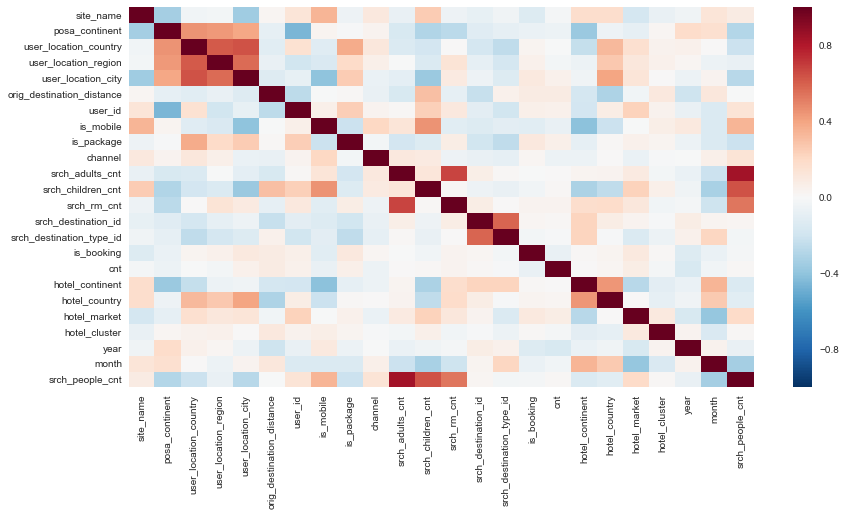

In [9]:
""" Pearson Correlation Coefficient using Seaborn Heatmap. """

pearson_corr = train.corr()
seaborn_corr = sb.heatmap(pearson_corr,xticklabels=pearson_corr.columns.values, yticklabels=pearson_corr.columns.values)
print seaborn_corr


In [10]:
""" Linear correlation on target value of Hotel Cluster. Results tell us there is no linear ordering (none are near 1 or -1). """

hotel_cluster_corr = train.corr()['hotel_cluster']
print hotel_cluster_corr.order(ascending=False)

hotel_cluster                1.000000
orig_destination_distance    0.104659
hotel_market                 0.095300
is_mobile                    0.067806
srch_children_cnt            0.060347
user_location_region         0.053300
user_location_country        0.045645
user_id                      0.041986
year                         0.037519
is_package                   0.028220
posa_continent               0.017371
srch_people_cnt              0.010269
is_booking                   0.008258
user_location_city           0.000234
srch_destination_id         -0.013032
channel                     -0.013903
cnt                         -0.021956
srch_adults_cnt             -0.028777
srch_rm_cnt                 -0.037784
srch_destination_type_id    -0.061288
site_name                   -0.072002
hotel_country               -0.091295
hotel_continent             -0.108342
month                       -0.151771
Name: hotel_cluster, dtype: float64


C:\Users\bth\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: order is deprecated, use sort_values(...)


In [11]:
""" Creates a subset with some categorical data to use for the following grouping analysis. """

train_cat = train[['hotel_cluster', 'site_name', 'posa_continent','srch_destination_id', 'channel', 'srch_rm_cnt', 'is_booking']]

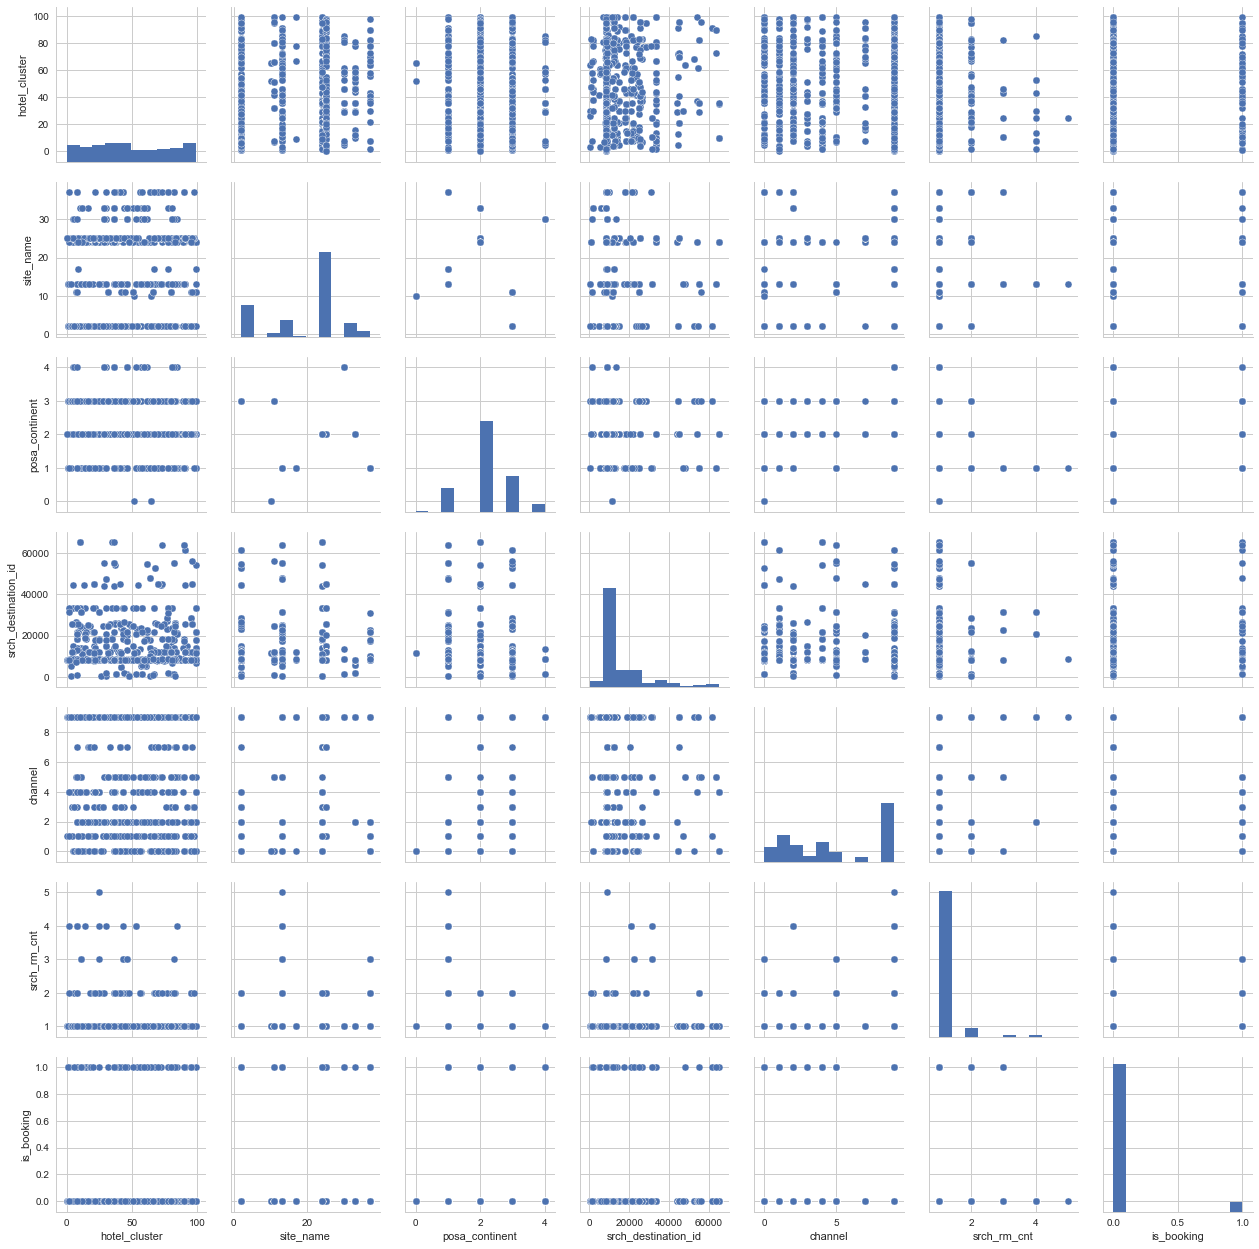

In [12]:
""" Uses categorical subgroup to create Seaborns Pair Grid summarizing variables pairs. """

print sb.pairplot(train_cat)

In [13]:
""" Use categorical subgroup to calculate mean of hotel cluster. """

hotel_cluster_groups = train_cat.groupby(train['hotel_cluster'])
print hotel_cluster_groups.mean()

               hotel_cluster  site_name  posa_continent  srch_destination_id  \
hotel_cluster                                                                  
0                        0.0  25.000000        2.000000          8278.000000   
1                        1.0  10.000000        2.000000          8250.000000   
2                        2.0  17.000000        2.000000         16375.500000   
3                        3.0   5.666667        2.333333          4833.000000   
4                        4.0  20.400000        2.200000         13213.600000   
5                        5.0  22.375000        2.375000         17928.250000   
6                        6.0   7.600000        3.200000          9587.600000   
7                        7.0   4.250000        3.000000         21352.500000   
8                        8.0  22.905660        1.943396         17095.452830   
9                        9.0  19.300000        2.100000         12681.900000   
10                      10.0  17.750000 

In [14]:
""" Use categorical subgroup to calculate statistics of whether booked. """

booking_group = train_cat.groupby('is_booking')
booking_group.describe()

channel  hotel_cluster  posa_continent   site_name  \
is_booking                                                                
False      count  936.000000     936.000000      936.000000  936.000000   
           mean     4.832265      48.192308        2.180556   19.731838   
           std      3.564631      28.971522        0.725757   10.210076   
           min      0.000000       0.000000        0.000000    2.000000   
           25%      1.000000      24.000000        2.000000   13.000000   
           50%      4.000000      43.000000        2.000000   24.000000   
           75%      9.000000      72.000000        3.000000   25.000000   
           max      9.000000      99.000000        4.000000   37.000000   
True       count   64.000000      64.000000       64.000000   64.000000   
           mean     5.109375      49.171875        1.968750   13.937500   
           std      3.060849      30.368402        0.942283   10.252177   
           min      0.000000       1.000000        1.000000    2.000000   
           25%      3.000000      18.750000        1.000000    2.000000   
           50%      5.000000      46.000000        2.000000   13.000000   
           75%      9.000000      78.000000        3.000000   24.000000   
           max      9.000000      99.000000        4.000000   37.000000   

                  srch_destination_id  srch_rm_cnt  
is_booking                                          
False      count           936.000000   936.000000  
           mean          15102.305556     1.105769  
           std           11619.482929     0.436967  
           min             267.000000     1.000000  
           25%            8278.000000     1.000000  
           50%            8811.000000     1.000000  
           75%           18488.250000     1.000000  
           max           65035.000000     5.000000  
True       count            64.000000    64.000000  
           mean          15923.921875     1.171875  
           std           14500.227078     0.489726  
           min            1385.000000     1.000000  
           25%            8267.000000     1.000000  
           50%            8811.000000     1.000000  
           75%           21141.750000     1.000000  
           max           65035.000000     3.000000

In [15]:
""" Use categorical subgroup to counts number of each site name. """

site_name_group = train_cat.groupby('site_name')
site_name_group.count()

,hotel_cluster,posa_continent,srch_destination_id,channel,srch_rm_cnt,is_booking
site_name,,,,,,
2,204,204,204,204,204,204
10,3,3,3,3,3,3
11,22,22,22,22,22,22
13,109,109,109,109,109,109
17,4,4,4,4,4,4
24,230,230,230,230,230,230
25,306,306,306,306,306,306
30,48,48,48,48,48,48
33,38,38,38,38,38,38


In [16]:
""" Group hotel cluster by whether or not booked. """

train.groupby(['hotel_cluster','is_booking']).mean()

site_name  posa_continent  user_location_country  \
hotel_cluster is_booking                                                     
0             False       25.000000        2.000000              23.000000   
1             False       11.000000        2.000000              49.400000   
              True         7.500000        2.000000              56.000000   
2             False       20.000000        1.800000              37.400000   
              True         2.000000        3.000000              66.000000   
3             False        5.666667        2.333333              59.333333   
4             False       20.400000        2.200000              31.600000   
5             False       22.375000        2.375000              42.375000   
6             False        9.000000        3.250000              98.250000   
              True         2.000000        3.000000              66.000000   
7             False        5.000000        3.000000             112.333333   
              True         2.000000        3.000000              66.000000   
8             False       23.078431        1.960784              17.705882   
              True        18.500000        1.500000              24.500000   
9             False       19.300000        2.100000              36.600000   
10            False       17.333333        2.333333              38.066667   
              True        24.000000        2.000000               3.000000   
11            False       19.285714        1.571429              21.428571   
              True        13.000000        1.000000              46.000000   
12            False       28.500000        2.000000              98.500000   
              True        24.000000        2.000000               3.000000   
13            False       13.500000        2.500000              44.500000   
14            False       14.833333        1.666667              33.166667   
15            False       13.000000        2.285714              36.142857   
              True        24.000000        2.000000               3.000000   
16            False       12.888889        2.222222              64.000000   
17            False       14.875000        2.250000              42.000000   
18            False       21.863636        2.136364              28.863636   
              True        17.333333        2.333333              37.333333   
19            False       25.000000        2.000000              23.000000   
...                             ...             ...                    ...   
78            True        30.500000        1.500000              36.000000   
79            False       13.500000        2.500000              44.500000   
80            False       14.166667        2.666667             121.166667   
              True        11.000000        3.000000             205.000000   
81            False       19.769231        2.692308              97.076923   
              True         2.000000        3.000000              66.000000   
82            False       21.000000        1.863636              53.681818   
              True        13.000000        1.000000              46.000000   
83            False       13.944444        2.222222              41.333333   
              True         2.000000        3.000000              66.000000   
84            False       22.444444        2.111111              27.777778   
85            False       21.333333        2.000000              49.333333   
              True        13.000000        1.000000              46.000000   
86            False       13.000000        1.000000              46.000000   
88            False       25.000000        2.000000              23.000000   
89            False       10.800000        2.600000              34.200000   
90            False       27.200000        1.400000              41.600000   
              True        13.000000        1.000000              46.000000   
91            False       19.476190        2.095

In [17]:
""" Create dataset and count events that resulted in booking. """

trainbooked = train[train.is_booking == True]
print ("Percent of searches that resulted in booking: %s which is (%s out of %s)"% 
       ((len(trainbooked)/float(len(train))), len(trainbooked), len(train)))
print
print trainbooked

Percent of searches that resulted in booking: 0.064 which is (64 out of 1000)

              date_time  site_name  posa_continent  user_location_country  \
1   2014-08-11 08:22:12          2               3                     66   
20  2014-02-27 18:01:32          2               3                     66   
27  2013-06-15 15:38:05         30               4                    195   
72  2014-11-23 18:02:20         30               4                    195   
79  2014-01-03 16:30:17          2               3                     66   
81  2014-01-03 16:44:56          2               3                     66   
83  2014-01-03 17:11:36          2               3                     66   
128 2014-10-29 14:32:19          2               3                     66   
133 2014-12-05 09:58:15          2               3                     66   
137 2013-01-10 18:30:08         37               1                     69   
158 2013-12-02 04:30:54         24               2                      3 

In [18]:
""" Lists most and least commonly searched hotel clusters. """

most_common_hotel_clusters_booked = list(trainbooked.hotel_cluster.value_counts().head(10).index)
print "Most Common Clusters Booked: " + str(most_common_hotel_clusters_booked)
most_common_hotel_clusters = list(train.hotel_cluster.value_counts().head(10).index)
print "Most Common Cluster Events: " + str(most_common_hotel_clusters)
print
least_common_hotel_clusters_booked = list(trainbooked.hotel_cluster.value_counts().tail(10).index)
print "Least Common Clusters Booked: " + str(least_common_hotel_clusters_booked)
least_common_hotel_clusters = list(train.hotel_cluster.value_counts().tail(10).index)
print "Least Common Clusters Events: " + str(least_common_hotel_clusters)

Most Common Clusters Booked: [95, 18, 36, 62, 11, 83, 91, 37, 15, 42]
Most Common Cluster Events: [8, 41, 36, 95, 99, 18, 54, 91, 25, 82]

Least Common Clusters Booked: [45, 51, 19, 82, 43, 40, 38, 99, 32, 64]
Least Common Clusters Events: [47, 49, 63, 76, 79, 0, 52, 71, 86, 92]


### Graphical Summaries (of categorical columns)

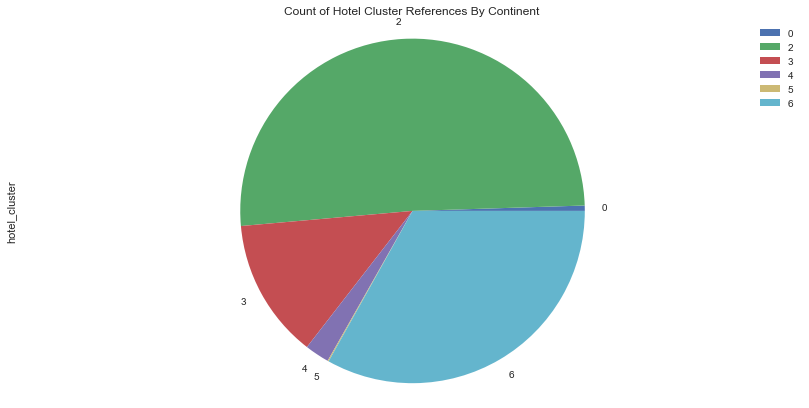

hotel_continent
0      5
2    509
3    131
4     23
5      1
6    331
Name: hotel_cluster, dtype: int64


In [19]:
"""Count of hotel clusters referenced by continent. """

count_cluster_by_continent = train.groupby(['hotel_continent'])['hotel_cluster'].count()
count_cluster_by_continent.plot(kind='pie', title='Count of Hotel Cluster References By Continent')
plt.axis('equal') 
plt.legend()
plt.show()
print count_cluster_by_continent

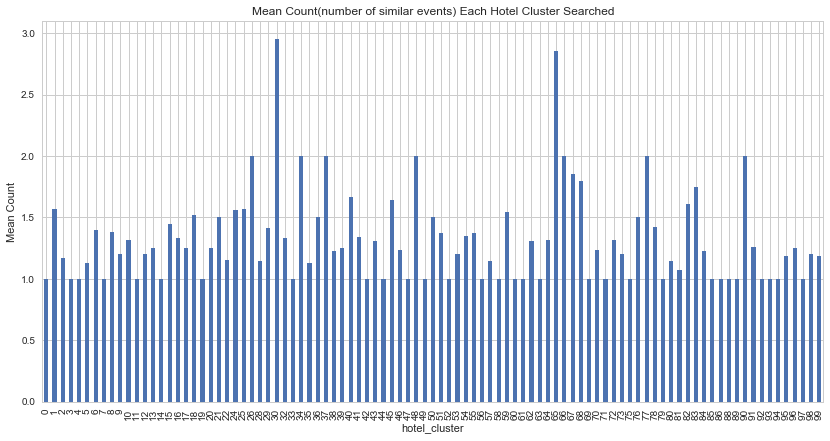

In [20]:
""" Mean Count(number of similar events) Each Hotel Cluster Searched. """

mean_count_by_cluster = train.groupby(['hotel_cluster'])['cnt'].mean()
mean_count_by_cluster.plot(kind='bar', title='Mean Count(number of similar events) Each Hotel Cluster Searched')
plt.ylabel('Mean Count')
plt.show()

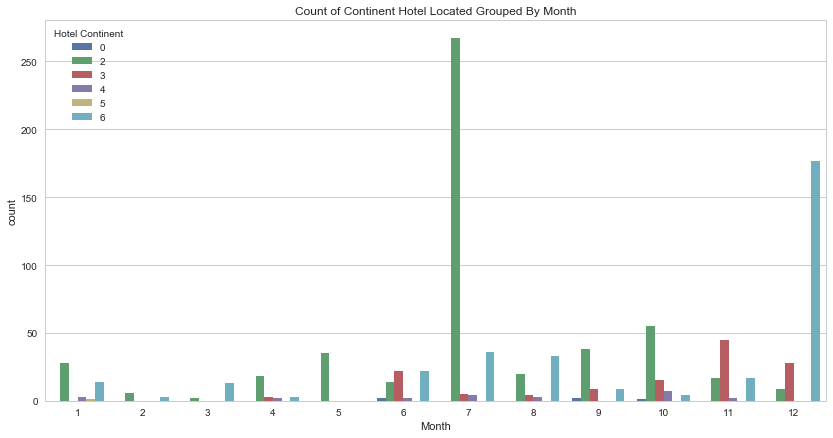

In [21]:
""" Comparison of Hotel Continent, grouped by month. """

sb.countplot(x='month', hue='hotel_continent', data=train)
plt.title("Count of Continent Hotel Located Grouped By Month")
plt.xlabel('Month')
plt.legend(title='Hotel Continent')
plt.show()

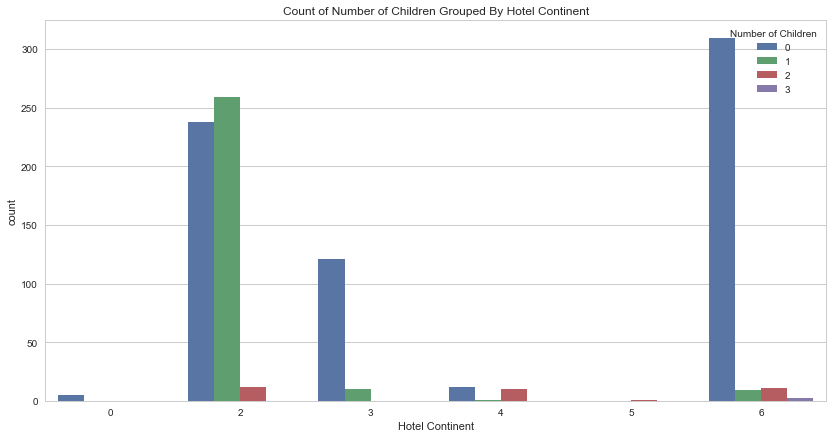

In [22]:
""" Comparison of Number of Children, grouped by Hotel Continent. """

sb.countplot(x='hotel_continent', hue='srch_children_cnt', data=train)
plt.title("Count of Number of Children Grouped By Hotel Continent")
plt.xlabel('Hotel Continent')
plt.legend(title='Number of Children')
plt.show()

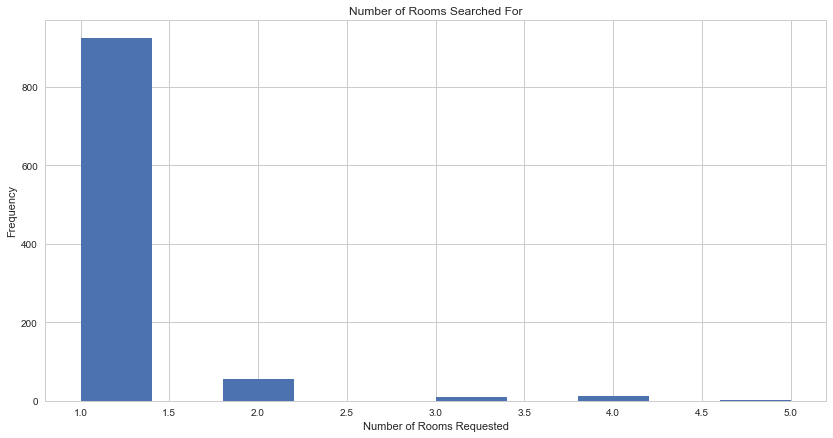

In [23]:
""" Histogram of Number of Rooms Searched For. """

plt.figure()
srch_room_number = train['srch_rm_cnt']
srch_room_number.plot(kind='hist', title='Number of Rooms Searched For')
plt.xlabel('Number of Rooms Requested')
plt.show()

The most frequent number of days searched is 0   1 days
dtype: timedelta64[ns]
The median number of days searched is 1 days 00:00:00


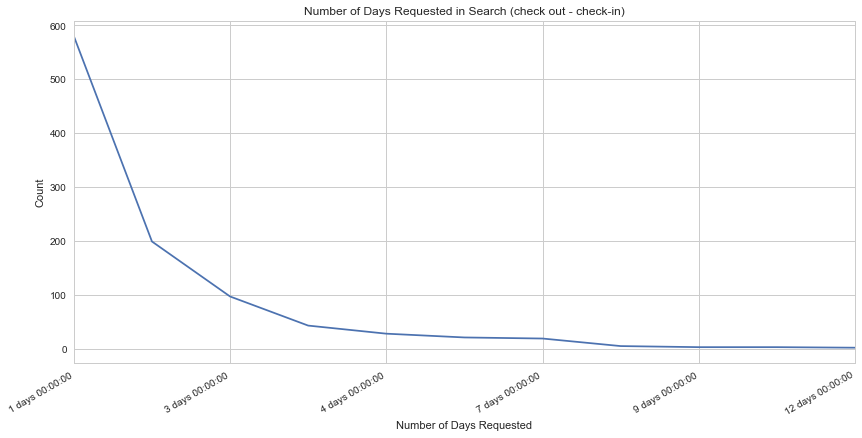

In [24]:
""" Number of days in search, length of stay calculated by check out - checkin. """

srch_length_of_stay_cnt = srch_length_of_stay.value_counts()

print "The most frequent number of days searched is "+str(srch_length_of_stay.mode())
print "The median number of days searched is "+str(srch_length_of_stay.median())
srch_length_of_stay_cnt.plot()
plt.title('Number of Days Requested in Search (check out - check-in)')
plt.ylabel('Count')
plt.xlabel('Number of Days Requested')
plt.show()

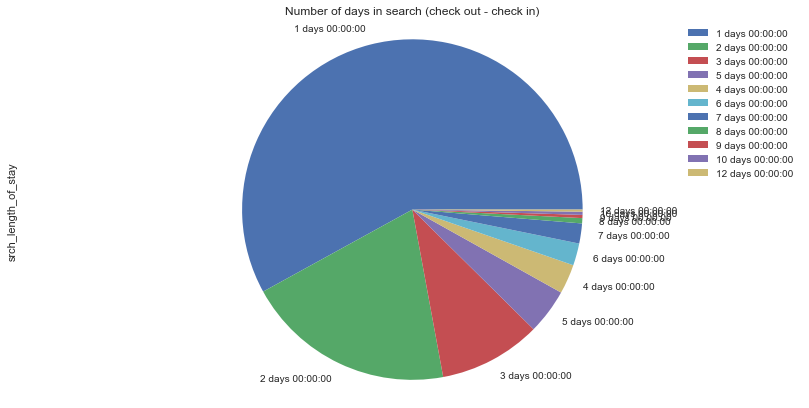

1 days     580
2 days     199
3 days      97
5 days      43
4 days      28
6 days      21
7 days      19
8 days       5
9 days       3
10 days      3
12 days      2
Name: srch_length_of_stay, dtype: int64


In [25]:
""" Number of days in search, length of stay calculated by check out - checkin. """

srch_length_stay_cnt = train['srch_length_of_stay'].value_counts()
srch_length_stay_cnt.plot(kind='pie', title='Number of days in search (check out - check in)')
plt.axis('equal') 
plt.legend()
plt.show()
print srch_length_stay_cnt

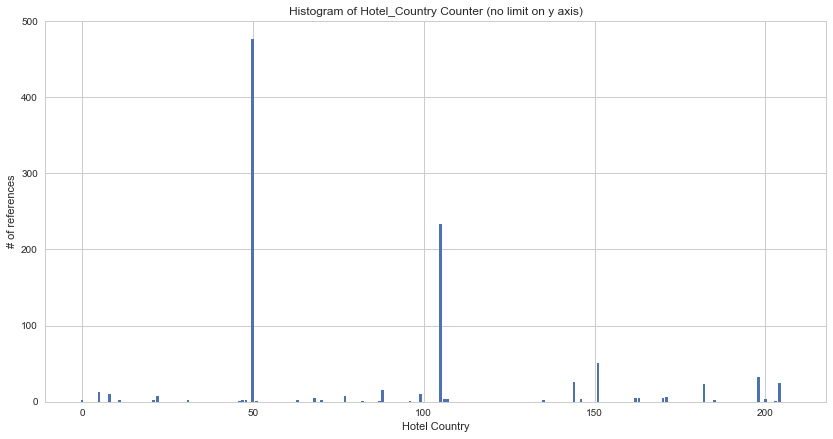

In [26]:
""" Histogram of Hotel Country (with no limit on y axis). """

hotel_country_count = collections.Counter(train['hotel_country'])
xs = range(max(train['hotel_country']))
ys = [hotel_country_count[x] for x in xs]
plt.bar(xs,ys)
plt.xlabel('Hotel Country')
plt.ylabel('# of references')
plt.title('Histogram of Hotel_Country Counter (no limit on y axis)')
plt.show()

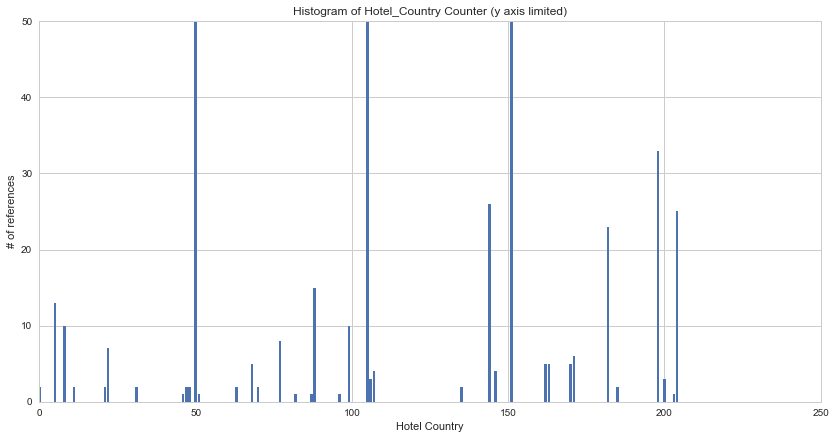

In [27]:
""" Histogram of Hotel Country (with y axis limited to 50 to show closeup of lower counts). """

hotel_country_count = collections.Counter(train['hotel_country'])
xs = range(max(train['hotel_country']))
ys = [hotel_country_count[x] for x in xs]
plt.bar(xs,ys)
plt.axis([0,250,0,50])
plt.xlabel('Hotel Country')
plt.ylabel('# of references')
plt.title('Histogram of Hotel_Country Counter (y axis limited)')
plt.show()

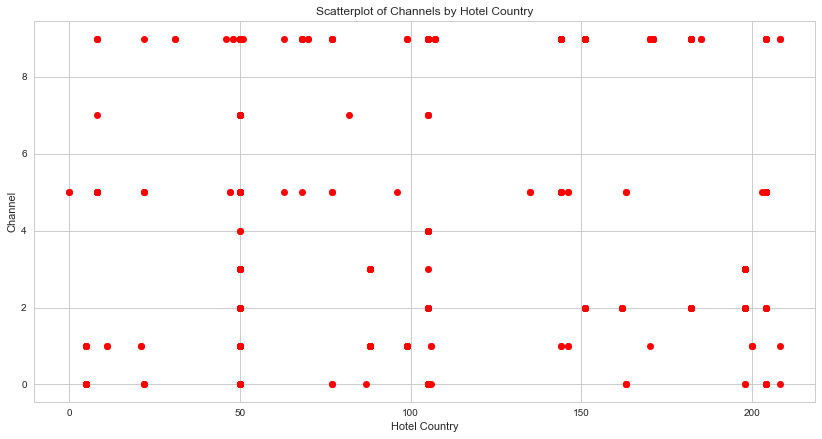

In [28]:
""" Scatterplot of Channels searched by Hotel Country. """

plt.plot(train['hotel_country'],train['channel'],'ro') 
plt.xlabel('Hotel Country')
plt.ylabel('Channel')
plt.title('Scatterplot of Channels by Hotel Country')
plt.show()

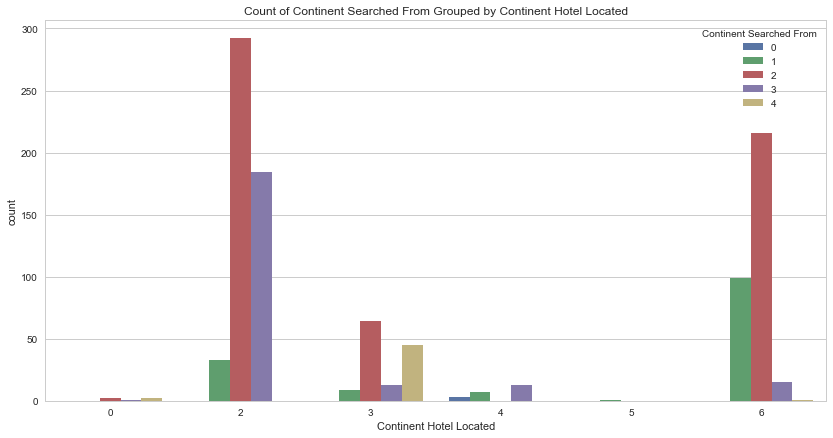

In [29]:
""" Comparison of Continent Searched, grouped by Continent Hotel Located. """

sb.countplot(x='hotel_continent', hue='posa_continent', data=train)
plt.title("Count of Continent Searched From Grouped by Continent Hotel Located")
plt.xlabel('Continent Hotel Located')
plt.legend(title='Continent Searched From')
plt.show()

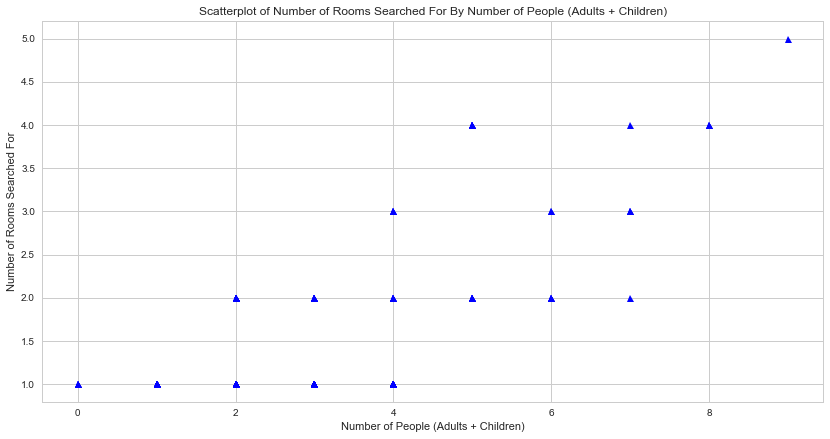

In [30]:
""" Scatterplot of number of people and number of rooms searched for. """

plt.plot(train['srch_people_cnt'],train['srch_rm_cnt'],'b^') 
plt.xlabel('Number of People (Adults + Children)')
plt.ylabel('Number of Rooms Searched For')
plt.title('Scatterplot of Number of Rooms Searched For By Number of People (Adults + Children)')
plt.show()

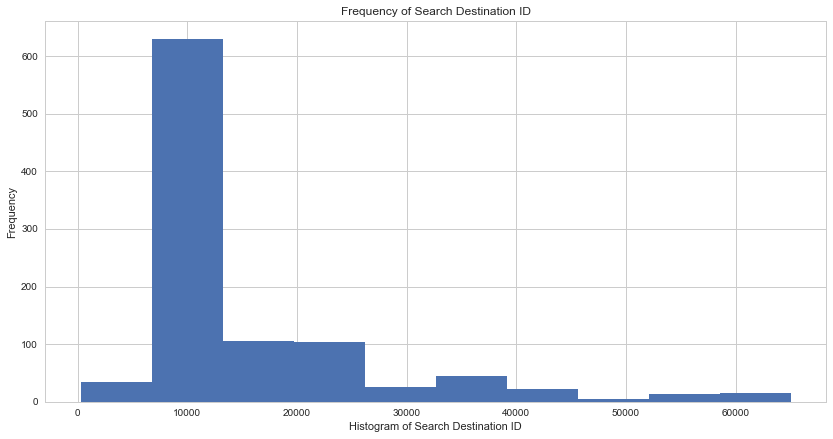

In [31]:
""" Histogram of Search Destination ID. """

plt.figure()
srch_room_number = train['srch_destination_id']
srch_room_number.plot(kind='hist', title='Frequency of Search Destination ID')
plt.xlabel('Histogram of Search Destination ID')
plt.show()

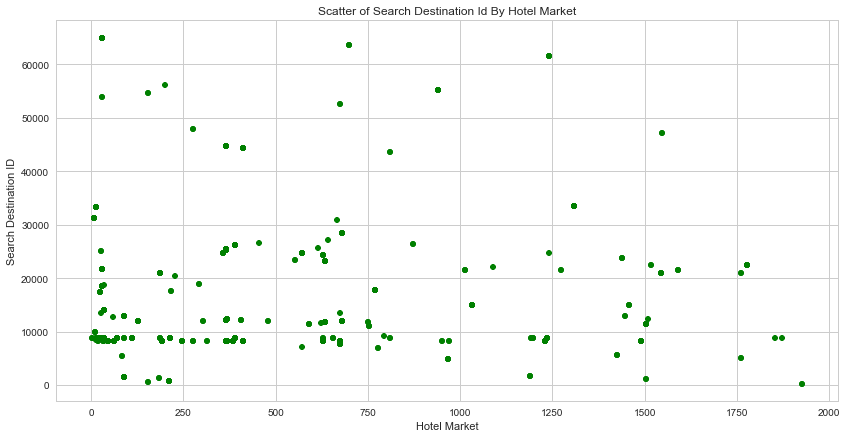

In [32]:
""" Scatterplot of Search Desination Id by Hotel Market. """

plt.plot(train['hotel_market'], train['srch_destination_id'],'g8') 
plt.xlabel('Hotel Market')
plt.ylabel('Search Destination ID')
plt.title('Scatter of Search Destination Id By Hotel Market')
plt.show()

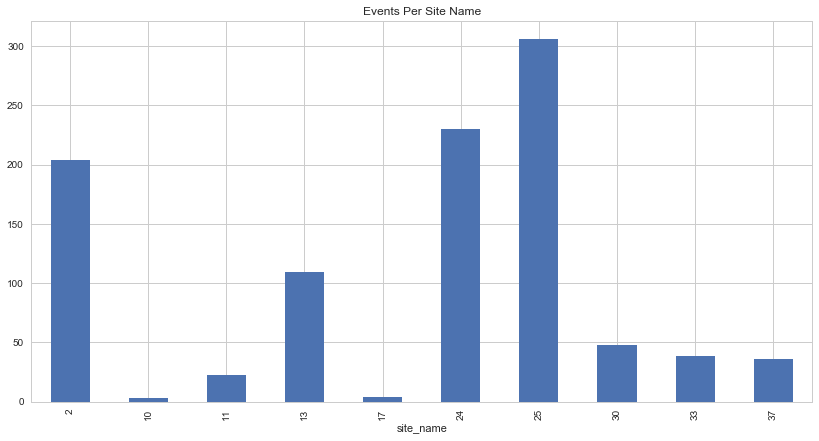

site_name
2     204
10      3
11     22
13    109
17      4
24    230
25    306
30     48
33     38
37     36
Name: is_booking, dtype: int64


In [33]:
""" Count of events per Site Name. """

site_name_booking_group = train.groupby(['site_name'])['is_booking'].count()
site_name_booking_group.plot(kind='bar', title='Events Per Site Name')
plt.show()
print site_name_booking_group

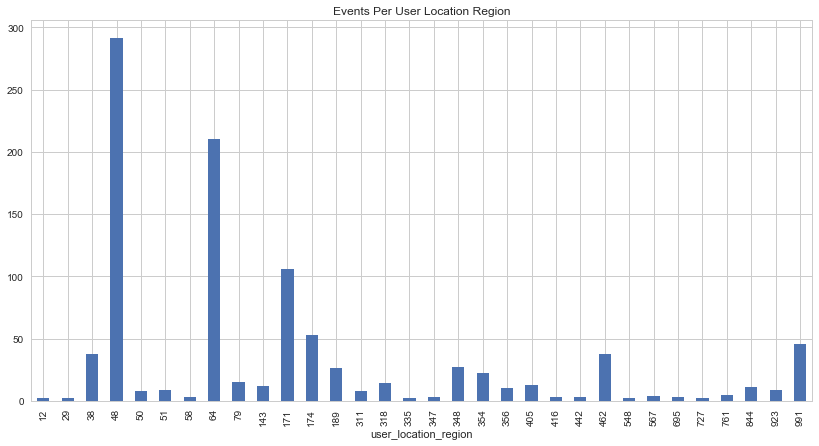

In [34]:
""" Count of events per User Location Region. """

user_location_booking_group = train.groupby(['user_location_region'])['is_booking'].count()
user_location_booking_group.plot(kind='bar', title='Events Per User Location Region')
plt.show()

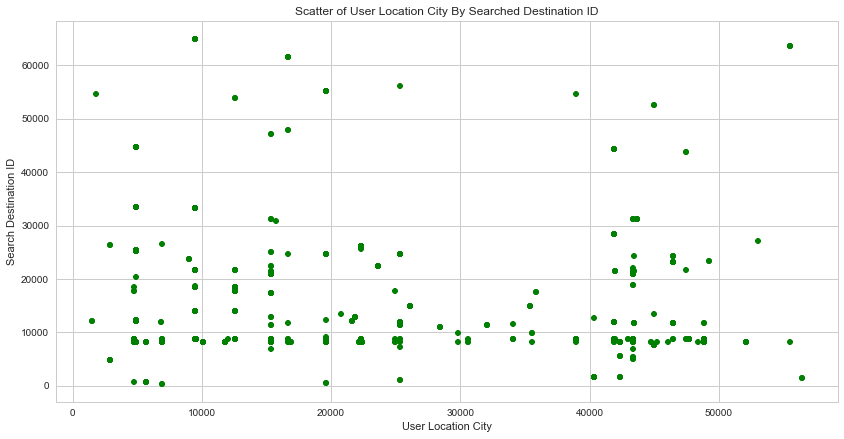

In [35]:
""" Scatterplot of Search User Location City By Searched Destination ID. """

plt.plot(train['user_location_city'], train['srch_destination_id'],'g8') 
plt.xlabel('User Location City')
plt.ylabel('Search Destination ID')
plt.title('Scatter of User Location City By Searched Destination ID')
plt.show()

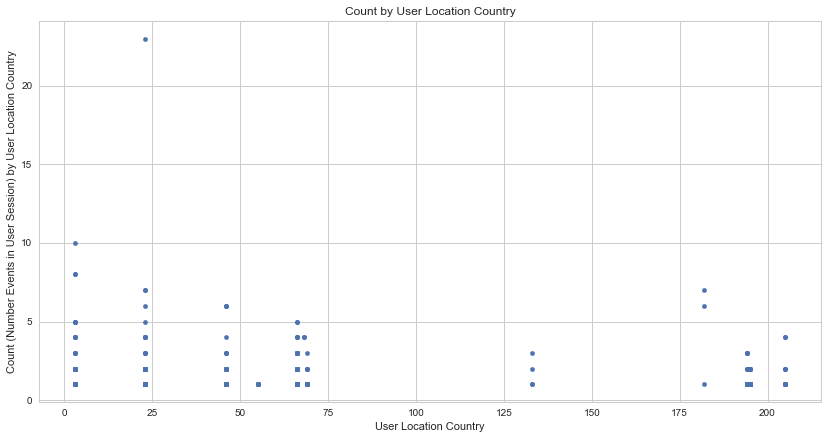

In [36]:
""" Scatterplot of Count By User Location Country. """

train.plot(kind='scatter', y='cnt', x='user_location_country', title = 'Count by User Location Country')
plt.xlabel("User Location Country")
plt.ylabel("Count (Number Events in User Session) by User Location Country")
plt.plot()
plt.show()

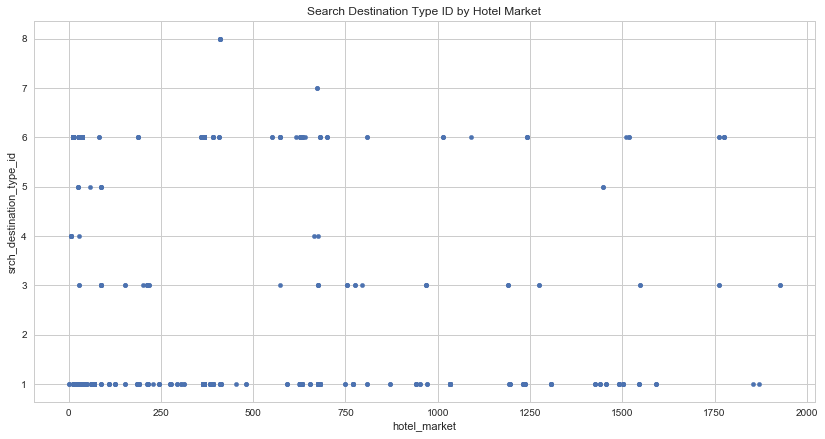

In [37]:
""" Scatterplot of Search Destination Type Id and Hotel Market. """

train.plot(kind='scatter', y='srch_destination_type_id', x='hotel_market', title = 'Search Destination Type ID by Hotel Market')
plt.plot()
plt.show()

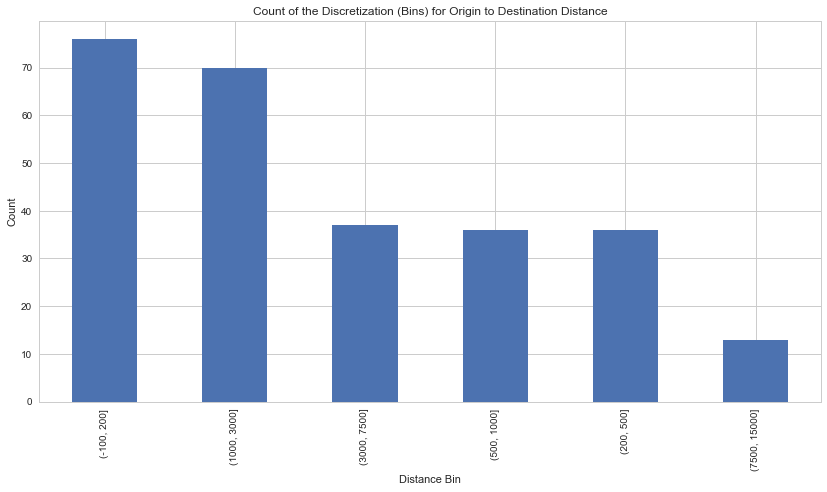

(-100, 200]      76
(1000, 3000]     70
(3000, 7500]     37
(500, 1000]      36
(200, 500]       36
(7500, 15000]    13
Name: orig_destination_distance, dtype: int64


In [38]:
""" Binning Origin to Destination Distance and then counting events in each bin. """

plt.figure()
bin_orig_dest_distance = pd.cut(train['orig_destination_distance'], [-100,200,500,1000,3000,7500,15000])
pd.value_counts(bin_orig_dest_distance).plot.bar()
plt.xlabel('Distance Bin')
plt.ylabel('Count')
plt.title('Count of the Discretization (Bins) for Origin to Destination Distance')
plt.show()
print pd.value_counts(bin_orig_dest_distance)

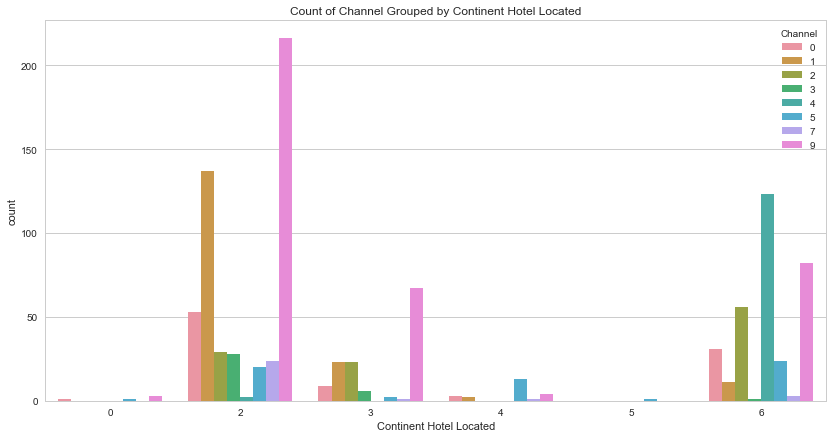

In [39]:
""" Comparison of Channel Grouped by Continent Continent Hotel Located. """

sb.countplot(x='hotel_continent', hue='channel', data=train)
plt.title("Count of Channel Grouped by Continent Hotel Located")
plt.xlabel('Continent Hotel Located')
plt.legend(title='Channel')
plt.show()

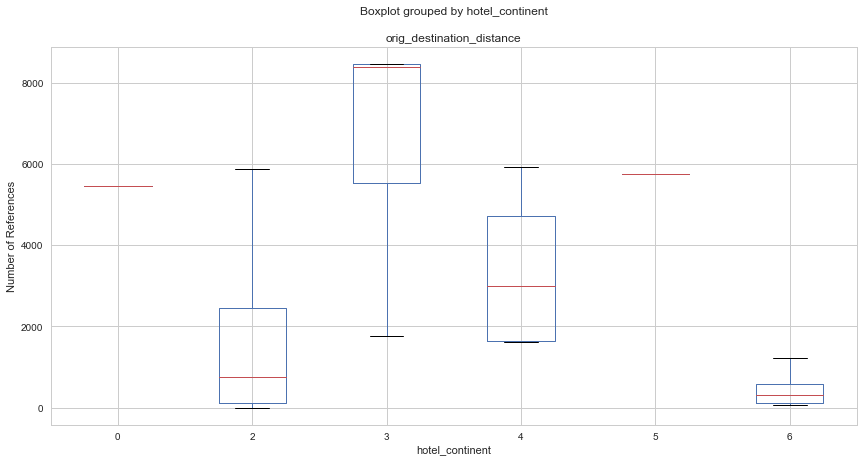

In [40]:
""" Boxplot of Origin to Destination Distances by Hotel Continent. """

train.boxplot(column='orig_destination_distance', by='hotel_continent')
plt.ylabel('Number of References')
plt.plot()
plt.show()

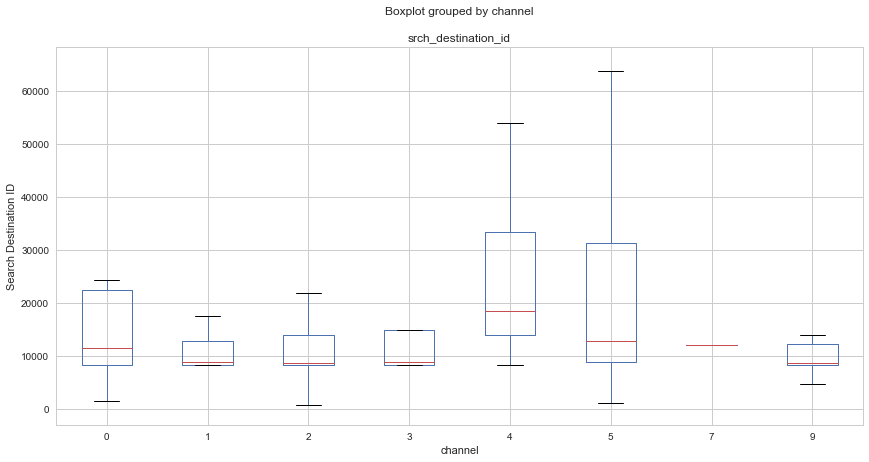

In [41]:
""" Boxplot of Search Destination Id By Channel. """

train.boxplot(column='srch_destination_id', by='channel')
plt.ylabel('Search Destination ID')
plt.plot()
plt.show()

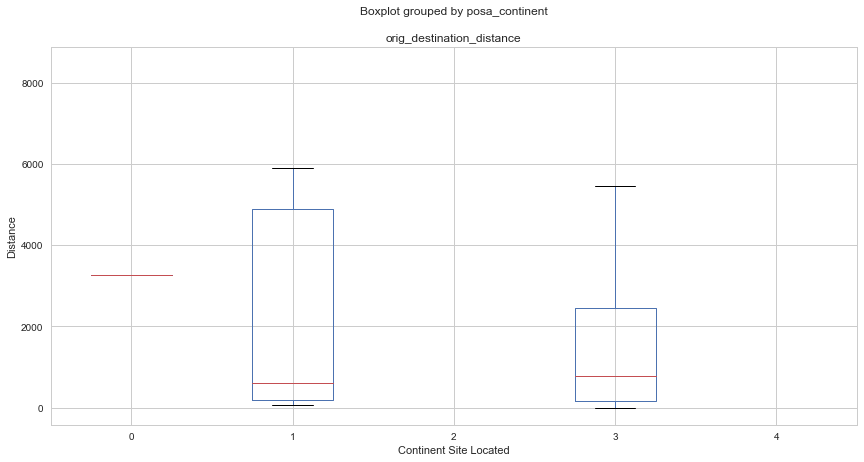

In [42]:
""" Boxplot of Origin to Destination Distances by Site Name Continent. """

train.boxplot(column='orig_destination_distance', by='posa_continent')
plt.ylabel('Distance')
plt.xlabel('Continent Site Located')
plt.plot()
plt.show()

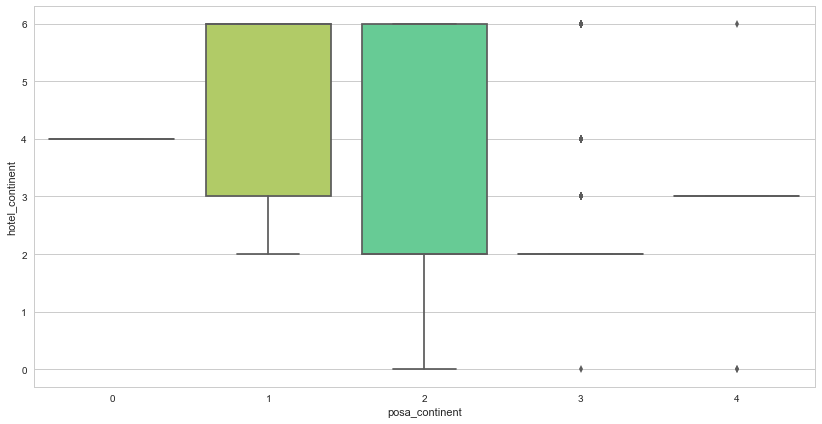

In [43]:
""" Seaborn Boxplot of Hotel Continent by Continent Site Located. """

sb.boxplot(y='hotel_continent', x='posa_continent', data=train, palette='hls')
plt.plot()
plt.show()

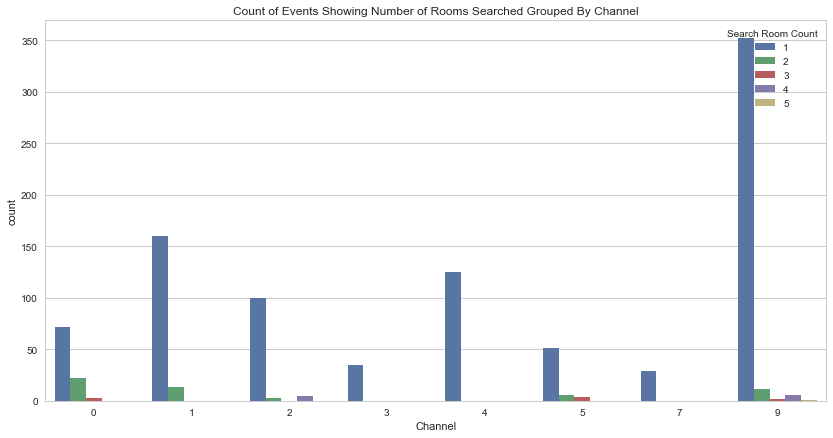

In [44]:
""" Number of Rooms Searched For, Grouped by Channel. """

sb.countplot(x='channel', hue='srch_rm_cnt', data=train)
plt.title("Count of Events Showing Number of Rooms Searched Grouped By Channel")
plt.xlabel('Channel')
plt.legend(title='Search Room Count')
plt.show()

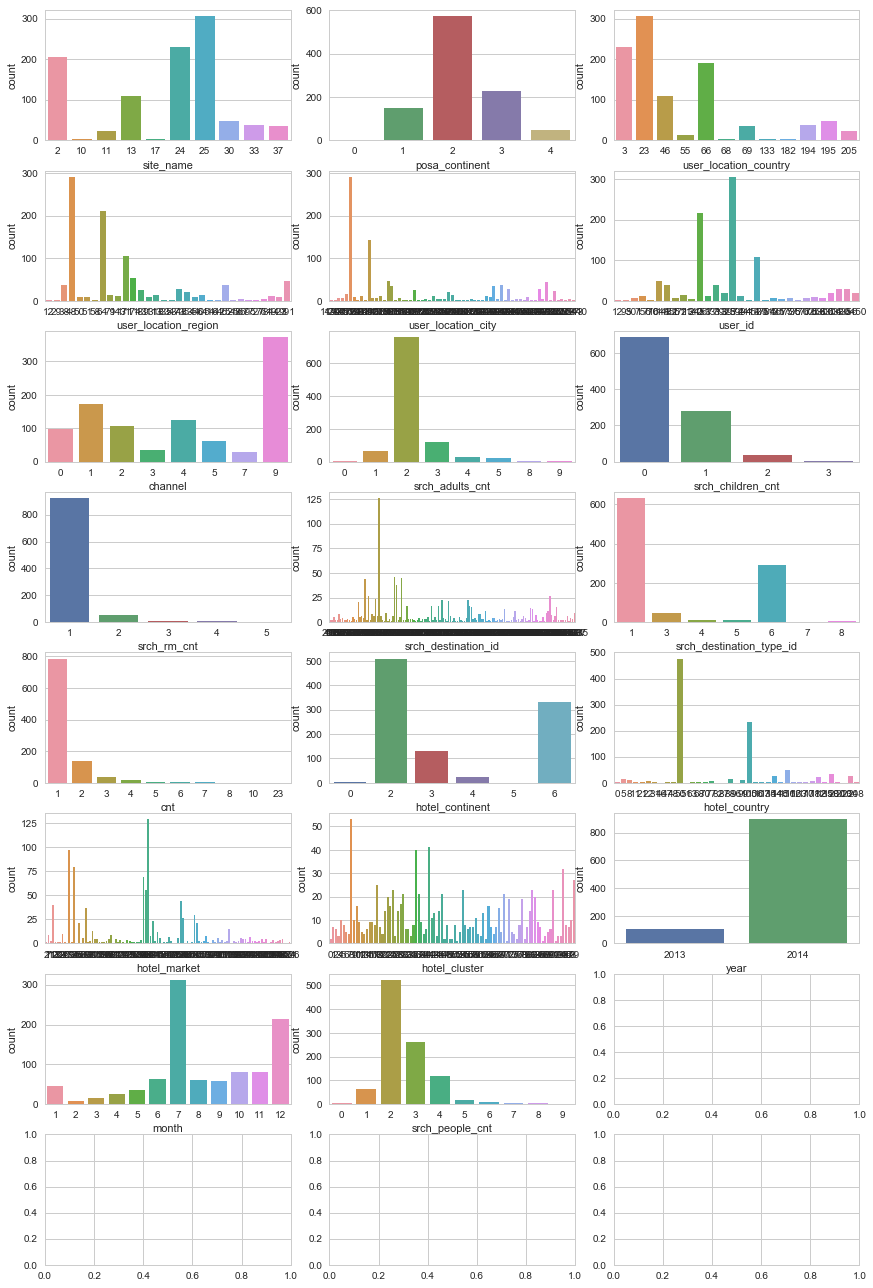

In [45]:
""" All Column Countplots (except date columns). """

rows = train.columns.size//3-1
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(12,18))
fig.tight_layout()
i = 0 
j = 0
for col in train.columns:
    if j>=3:
        j=0
        i+=1
    if train[col].dtypes == np.int64:
        sb.countplot(x=col, data=train, ax=axes[i][j])
        j+=1

### Numerical Summaries (of columns: is_mobile, is_package, is_booking, cnt)


In [46]:
""" Create subset of numeric and boolean data to use in grouping. """

train_numbers = train[['hotel_cluster', 'cnt', 'is_booking', 'is_package', 'is_mobile']]

In [47]:
""" For numeric subset, calculate mean values. """

print train_numbers.mean()

hotel_cluster    48.255
cnt               1.395
is_booking        0.064
is_package        0.140
is_mobile         0.343
dtype: float64


In [48]:
""" For numeric subset, calculate median values. """

print train_numbers.median()

hotel_cluster    43.0
cnt               1.0
is_booking        0.0
is_package        0.0
is_mobile         0.0
dtype: float64


In [49]:
""" For numeric subset, calculate most frequent values. """

print train_numbers.mode()

   hotel_cluster  cnt is_booking is_package is_mobile
0              8    1      False      False     False


In [50]:
""" For numeric subset, calculate statistical summary of non-boolean columns. """

train_numbers.describe()

,hotel_cluster,cnt
count,1000.000000,1000.000000
mean,48.255000,1.395000
std,29.048128,1.159448
min,0.000000,1.000000
25%,24.000000,1.000000
50%,43.000000,1.000000
75%,72.000000,1.000000
max,99.000000,23.000000


In [51]:
""" For numeric subset, group by whether package. """

package_group = train_numbers.groupby('is_package')
print package_group.mean()

            hotel_cluster       cnt  is_booking  is_mobile
is_package                                                
False           47.924419  1.366279    0.053488   0.384884
True            50.285714  1.571429    0.128571   0.085714


In [52]:
""" For numeric subset, calculate percentages. """

for x in train[['is_booking', 'is_package', 'is_mobile', 'cnt']]:
    count = train[x].value_counts()
    total = len(train)
    percent = count/total
    print x
    print percent
    print

is_booking
False    0.936
True     0.064
Name: is_booking, dtype: float64

is_package
False    0.86
True     0.14
Name: is_package, dtype: float64

is_mobile
False    0.657
True     0.343
Name: is_mobile, dtype: float64

cnt
1     0.784
2     0.138
3     0.037
4     0.021
5     0.008
6     0.005
7     0.003
8     0.002
23    0.001
10    0.001
Name: cnt, dtype: float64



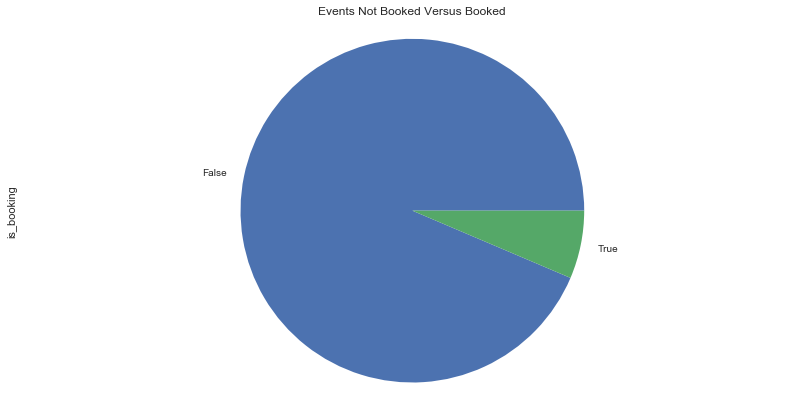

False    936
True      64
Name: is_booking, dtype: int64


In [53]:
""" Counting events booked versus not booked. """

booking_count = train['is_booking'].value_counts()
booking_count.plot(kind='pie', title='Events Not Booked Versus Booked')
plt.axis('equal') 
plt.show()
print booking_count

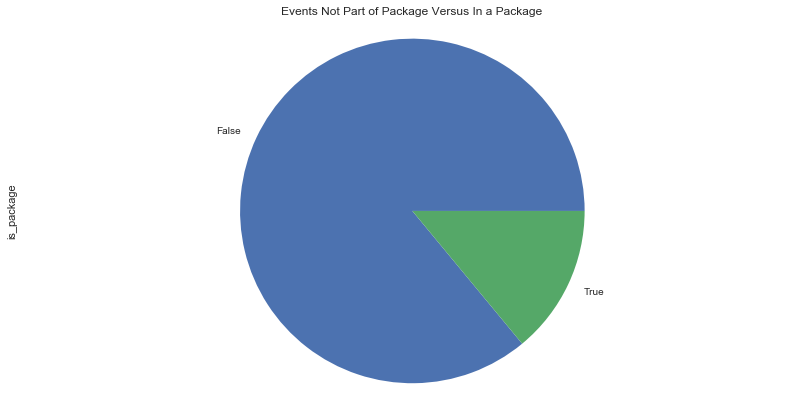

False    860
True     140
Name: is_package, dtype: int64


In [54]:
"""Count of events without and with package."""

pkg_count = train['is_package'].value_counts()
pkg_count.plot(kind='pie', title='Events Not Part of Package Versus In a Package')
plt.axis('equal') 
plt.show()
print pkg_count

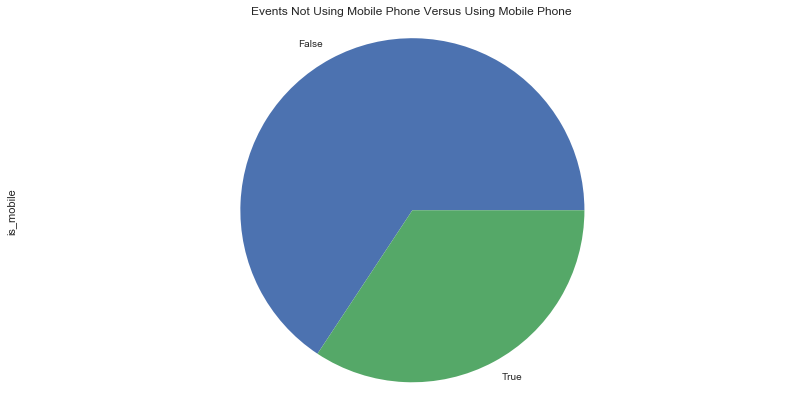

False    657
True     343
Name: is_mobile, dtype: int64


In [55]:
""" Counting events without and with mobile. """

mobile_count = train['is_mobile'].value_counts()
mobile_count.plot(kind='pie', title='Events Not Using Mobile Phone Versus Using Mobile Phone')
plt.axis('equal') 
plt.show()
print mobile_count

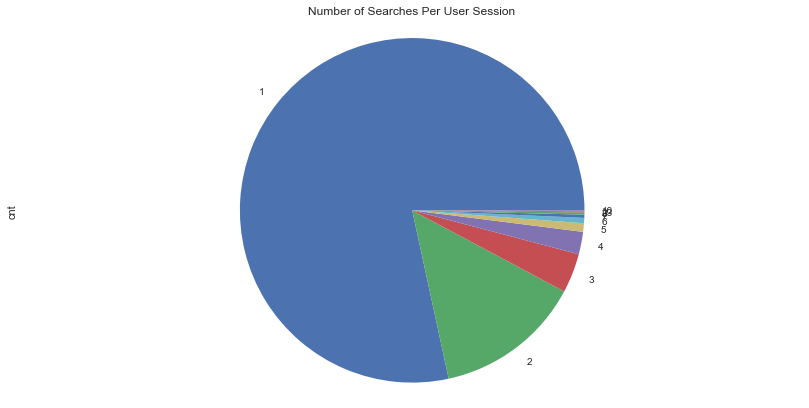

1     784
2     138
3      37
4      21
5       8
6       5
7       3
8       2
23      1
10      1
Name: cnt, dtype: int64


In [56]:
""" Count of searches per event. """

counts_count = train['cnt'].value_counts()
counts_count.plot(kind='pie', title='Number of Searches Per User Session')
plt.axis('equal') 
plt.show()
print counts_count

In [57]:
""" Stats on number of related events per user session"""

print "Number of related events per user session (cnt)"
print "   mean \t" + str(train['cnt'].mean())
print "   median \t" + str(train['cnt'].median())
print "   max value \t" + str(train['cnt'].max())

Number of related events per user session (cnt)
   mean 	1.395
   median 	1.0
   max value 	23


               hotel_cluster       cnt  is_booking  is_package  is_mobile
hotel_cluster       1.000000 -0.021956    0.008258    0.028220   0.067806
cnt                -0.021956  1.000000   -0.075026    0.061426  -0.077227
is_booking          0.008258 -0.075026    1.000000    0.106445  -0.111475
is_package          0.028220  0.061426    0.106445    1.000000  -0.218676
is_mobile           0.067806 -0.077227   -0.111475   -0.218676   1.000000
Axes(0.125,0.125;0.62x0.755)


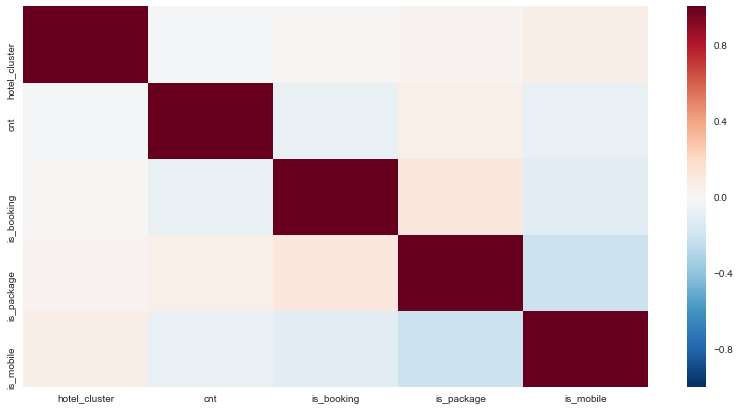

In [58]:
""" For numeric subset, use Seaborn heatmap to visualize Pearson Correlation Coefficient. """

pearson_corr = train_numbers.corr()
print pearson_corr
seaborn_corr = sb.heatmap(pearson_corr, xticklabels=pearson_corr.columns.values, yticklabels=pearson_corr.columns.values)
print seaborn_corr

# 3. TripSearch Class

### Defines TripSearch Class and Methods

My TripSearch class is set up to track each trip (row) from the Expedia file as a separate instance. All these instances into a list called all_trip_searches.  Two of the class methods are operator overloading (init, repr). One method collects the searches for a specific user (user_searches).  Three of the class methods create lists with subsets of trips: such as determining if the length of stay would be considered a long vacation (is_long_vacation), grouping based on how far the distance is between origin and destination (distance_group), and separating the trips that resulted in a booking (is_booked). These lists can be used to analyze trends. One method does a fancy print of focused information for a specific hotel market (show_hotel_info).

Most of these are set up with the variables listed at the top of the kernel to allow adjustments before the method is called. For instance, you can easily specify the number of days you consider a long vacation or the breakpoints between distance groups for the origin/destination bins. This allows you to try different situations to discern which provide the most meaningful information. 




In [59]:


class TripSearch():
    """ 
    Each instance in the TripSearch class is a different search made on Expedia. all_trip_searches is a 
    dataset that contains all the instances (all the rows) of Trip Search. 
    """
    
    def __init__(self,data_object):
        """
        __init__ is a constructor method which initializes instance attributes.
        
        This method is run the first time a TripSearch instance is created. It assigns
        the first values to that instance. The value passed in is a data_object 
        which is then assigned to this particular instance by use of keyword self.
        """
        self.date_time = data_object.date_time
        self.site_name = data_object.site_name
        self.posa_continent = data_object.posa_continent
        self.user_location_country = data_object.user_location_country
        self.user_location_region = data_object.user_location_region
        self.user_location_city = data_object.user_location_city
        self.orig_destination_distance = data_object.orig_destination_distance
        self.user_id = data_object.user_id
        self.is_mobile = data_object.is_mobile
        self.is_package = data_object.is_package
        self.channel = data_object.channel
        self.srch_ci = data_object.srch_ci
        self.srch_co = data_object.srch_co
        self.srch_adults_cnt = data_object.srch_adults_cnt
        self.srch_children_cnt = data_object.srch_children_cnt
        self.srch_rm_cnt = data_object.srch_rm_cnt
        self.srch_destination_id = data_object.srch_destination_id
        self.srch_destination_type_id = data_object.srch_destination_type_id
        self.is_booking = data_object.is_booking
        self.cnt = data_object.cnt
        self.hotel_continent = data_object.hotel_continent
        self.hotel_country = data_object.hotel_country
        self.hotel_market = data_object.hotel_market
        self.hotel_cluster = data_object.hotel_cluster
        self.srch_length_of_stay = data_object.srch_length_of_stay
        self.srch_people_cnt = data_object.srch_people_cnt 
        self.year = data_object.year
        self.month = data_object.month
        
    def __repr__(self):
        """ 
        __repr__ is a custom displays format for TripSearch Class. 
        
        This method is automatically called when a TripClass instances is printed or converted to strings
        It is an operater overloader which replaces the default printing of instances (which prints only 
        the object's class name and memory address). 
        
        Returns:
            String with all the columns in the dataset.
        """
        return str("\nUser ID: %s "
                   "\nDate %s \nSite Name: %s \nSite Continent: %s"
                   "\nUser Country: %s \nUser Region: %s \nUser City: %s "
                   "\nMoble: %s \nPackage: %s \nChannel: %s"
                   "\nCheck in: %s \nCheck out: %s \nLength: %s"
                   "\nNum Adults: %s \nNum Children: %s \nTotal People: %s"
                   "\nNum Rooms: %s \nDistance (origin to dest): %s "
                   "\nSearch Destination ID: %s \nSearch Destination Type: %s"
                   "\nHotel Continent: %s \nHotel Country %s"
                   "\nHotel Market: %s \nHotel Cluster: %s"
                   "\nBooked: %s \nCount (similar events for user in session): %s \n"
                % (self.user_id, self.date_time, self.site_name, self.posa_continent,  
                self.user_location_country,self.user_location_region, self.user_location_city,
                self.is_mobile, self.is_package, self.channel, self.srch_ci, self.srch_co, 
                self.srch_length_of_stay, self.srch_adults_cnt, self.srch_children_cnt, 
                self.srch_people_cnt, self.srch_rm_cnt, self.orig_destination_distance, 
                self.srch_destination_id, self.srch_destination_type_id, self.hotel_continent, 
                self.hotel_country, self.hotel_market, self.hotel_cluster, self.is_booking, 
                self.cnt))
 
    def is_long_vacation (self, numbdays):
        """ 
        Checks if number of days is greater than or equal to the number of days that are considered a long vacation.
        
        Keyword Arguments:
            numbdays - the number of days defining a long vacation
        
        Returns:
            True (if length_of_stay is greater than or equal to numbdays)
            False (if length_of_stay is less than numbdays)
        """
        return self.srch_length_of_stay >= datetime.timedelta(days=numbdays) 
            
    def distance_group(self, dist1, dist2, dist3):
        """ 
        Assigns a distance group for specific instance using origin to destination distance and user entered break points.
        
        Keyword Arguments:
            dist1 - the first breakpoint (all distances below this number are group1)
            dist2 - the second breakpoint
            dist3 - the third breakpoint
        Returns:
            distance group number the instance is assigned to (1,2,3,4)
        """        
        if self.orig_destination_distance < dist1:
            return 1
        elif self.orig_destination_distance <dist2:
            return 2
        elif self.orig_destination_distance <dist3:
            return 3
        else:
            return 4

    def user_searches(self, this_user):
        """ 
        Checks if this instance is the user you are searching for.
        
        Keyword Arguments:
            this_user - the user being searched for.
        
        Returns:
            True (if it is the user)
            False (if it is not the user)
        """
        return self.user_id == this_user 
    
    def show_hotel_info(self, hotel_market_number):
        """ 
        Displays relevant information for hotel searches that match a specific hotel_market number. 
        
        Keyword Arguments: 
            hotel_market_number - the specific hotel you want to display information for.
            
        Returns:
            Nothing is returned, but key fields are displayed (cluster, whether package, length of stay, room count
            origin to destination distance, channel, and whether booked). 
        """
        if self.hotel_market == hotel_market_number:
            print str("\nHotel Market: %s \nHotel Cluster: %s \nPart of Package: %s \nLength of Stay: %s \nRoom Count: %s"
                   "\nOrig to Destination Distance: %s \nBooking Channel: %s \nBooked: %s"
                    % (self.hotel_market, self.hotel_cluster, self.is_package, self.srch_length_of_stay, self.srch_rm_cnt, 
                       self.orig_destination_distance, self.channel, self.is_booking))

    def is_booked (self):
        """ 
        Checks if the trip resulted in a booking.
        
        Returns:
            True (if trip search resulted in booking)
            False (if trip search did not result in booking)
        """
        return self.is_booking
            

### Examples of how to use the class TripSearch

In [60]:
""" 
Creates an TripSearch class instance for each row from the train dataset. 
Saves these instances in a list named all_trip_searches. 
"""
all_trip_searches = []
for index, row in train.iterrows():
    this_trip_search = TripSearch(row)
    all_trip_searches.append(this_trip_search)

In [61]:
""" 
Counts and creates a list of long vacations (defined as length_of_stay greater than or equal to numb_days).  
Uses TripSearch class method is_long_vacation. 
You can define numb_days of what is considered a long trip.
Saves the trips in a list named long_vacations.
"""
numb_days = 5    # You can enter criteria for what is considered a long trip

long_vacations = []
long_vacation_count = 0
for trip in all_trip_searches:
    result=trip.is_long_vacation(numb_days)
    if result == True:
        long_vacations.append(trip)
        long_vacations.append(result)
        long_vacation_count +=1
print "Number of Long Vacations (%s days or longer): %s" % (numb_days, long_vacation_count)
print long_vacations

Number of Long Vacations (5 days or longer): 96
[
User ID: 93 
Date 2014-08-09 18:05:16 
Site Name: 2 
Site Continent: 3
User Country: 66 
User Region: 442 
User City: 35390 
Moble: False 
Package: False 
Channel: 3
Check in: 2014-11-23 00:00:00 
Check out: 2014-11-28 00:00:00 
Length: 5 days 00:00:00
Num Adults: 2 
Num Children: 0 
Total People: 2
Num Rooms: 1 
Distance (origin to dest): 913.1932 
Search Destination ID: 14984 
Search Destination Type: 1
Hotel Continent: 2 
Hotel Country 50
Hotel Market: 1457 
Hotel Cluster: 80
Booked: False 
Count (similar events for user in session): 1 
, True, 
User ID: 93 
Date 2014-08-09 18:08:18 
Site Name: 2 
Site Continent: 3
User Country: 66 
User Region: 442 
User City: 35390 
Moble: False 
Package: False 
Channel: 3
Check in: 2014-11-23 00:00:00 
Check out: 2014-11-28 00:00:00 
Length: 5 days 00:00:00
Num Adults: 2 
Num Children: 0 
Total People: 2
Num Rooms: 1 
Distance (origin to dest): 913.6259 
Search Destination ID: 14984 
Search Destin

In [62]:
""" 
Counts and creates 4 groups, based on distance from origin to destination. 
Uses TripSearch class method distance_group.
You can define the break points for each distance group. 
Saves the trips in lists named group1_distance, group2_distance, group3_distance, group4_distance
"""
dist1 = 500    # You can define the break points for each group
dist2 = 3000   # You can define the break points for each group
dist3 = 8000   # You can define the break points for each group

group1_distance = []
group1_distance_count = 0
group2_distance = []
group2_distance_count = 0
group3_distance = []
group3_distance_count = 0
group4_distance = []
group4_distance_count = 0
for trip in all_trip_searches:
    result=trip.distance_group(dist1, dist2, dist3)
    if result == 1:
        group1_distance.append(trip)
        group1_distance.append(result)
        group1_distance_count +=1
    if result == 2:
        group2_distance.append(trip)
        group2_distance.append(result)
        group2_distance_count +=1
    if result == 3:
        group3_distance.append(trip)
        group3_distance.append(result)
        group3_distance_count +=1
    if result == 4:
        group4_distance.append(trip)
        group4_distance.append(result)
        group4_distance_count +=1
print "Number of Trips With Distance Less than %s miles:  %s" % (dist1, group1_distance_count)
print "Number of Trips With Distance Between %s and %s miles:  %s" % (dist1, dist2, group2_distance_count)
print "Number of Trips With Distance Between %s and %s miles:  %s" % (dist2, dist3, group3_distance_count)
print "Number of Trips With Distance Over %s miles:  %s" % (dist3, group4_distance_count)
print
print
print "Trips With Distance Less than %s miles" % (dist1)
print group1_distance
print "Trips With Distance Between %s and %s miles" % (dist1, dist2)
print group2_distance
print "Trips With Distance Between %s and %s miles" % (dist2, dist3)
print group3_distance
print "Trips With Distance Over %s miles" % (dist3)
print group4_distance

Number of Trips With Distance Less than 500 miles:  112
Number of Trips With Distance Between 500 and 3000 miles:  106
Number of Trips With Distance Between 3000 and 8000 miles:  37
Number of Trips With Distance Over 8000 miles:  745


Trips With Distance Less than 500 miles
[
User ID: 756 
Date 2014-01-17 06:24:56 
Site Name: 2 
Site Continent: 3
User Country: 66 
User Region: 318 
User City: 22418 
Moble: False 
Package: True 
Channel: 9
Check in: 2014-04-17 00:00:00 
Check out: 2014-04-20 00:00:00 
Length: 3 days 00:00:00
Num Adults: 2 
Num Children: 0 
Total People: 2
Num Rooms: 1 
Distance (origin to dest): 420.6642 
Search Destination ID: 8291 
Search Destination Type: 1
Hotel Continent: 2 
Hotel Country 50
Hotel Market: 191 
Hotel Cluster: 18
Booked: False 
Count (similar events for user in session): 5 
, 1, 
User ID: 756 
Date 2014-01-21 06:39:08 
Site Name: 2 
Site Continent: 3
User Country: 66 
User Region: 318 
User City: 22418 
Moble: False 
Package: True 
Channel: 2
Check 

In [63]:
""" 
Creates list of searches made by a specific user. 
Uses TripSearch class method user_searches.
You define user_id of the user whose searches you want to display.
Saves the trips in a list named this_users_searches
"""
this_user = 756    # You can enter the specific user you are searching for

this_users_searches = []
for trip in all_trip_searches:
    result=trip.user_searches(this_user)
    if result == True:
        this_users_searches.append(trip)
print "Number of searches made by user number: %s" % (this_user)
print this_users_searches

Number of searches made by user number: 756
[
User ID: 756 
Date 2014-01-17 06:24:56 
Site Name: 2 
Site Continent: 3
User Country: 66 
User Region: 318 
User City: 22418 
Moble: False 
Package: True 
Channel: 9
Check in: 2014-04-17 00:00:00 
Check out: 2014-04-20 00:00:00 
Length: 3 days 00:00:00
Num Adults: 2 
Num Children: 0 
Total People: 2
Num Rooms: 1 
Distance (origin to dest): 420.6642 
Search Destination ID: 8291 
Search Destination Type: 1
Hotel Continent: 2 
Hotel Country 50
Hotel Market: 191 
Hotel Cluster: 18
Booked: False 
Count (similar events for user in session): 5 
, 
User ID: 756 
Date 2014-01-18 14:33:31 
Site Name: 2 
Site Continent: 3
User Country: 66 
User Region: 318 
User City: 52078 
Moble: False 
Package: True 
Channel: 9
Check in: 2014-04-16 00:00:00 
Check out: 2014-04-19 00:00:00 
Length: 3 days 00:00:00
Num Adults: 2 
Num Children: 0 
Total People: 2
Num Rooms: 1 
Distance (origin to dest): nan 
Search Destination ID: 8291 
Search Destination Type: 1
Hote

In [64]:
""" 
Displays relevant information for specific Hotel Market Searches
Uses TripSearch class method show_hotel_info.
You define the market number for which you want searches displayed.
"""
hotel_market_number = 191   # You can enter the specific hotel_market you are searching for

specific_hotel_market = []
for trip in all_trip_searches:
    trip.show_hotel_info(hotel_market_number)


Hotel Market: 191 
Hotel Cluster: 18 
Part of Package: True 
Length of Stay: 3 days 00:00:00 
Room Count: 1
Orig to Destination Distance: 420.6642 
Booking Channel: 9 
Booked: False

Hotel Market: 191 
Hotel Cluster: 28 
Part of Package: True 
Length of Stay: 3 days 00:00:00 
Room Count: 1
Orig to Destination Distance: nan 
Booking Channel: 9 
Booked: False

Hotel Market: 191 
Hotel Cluster: 25 
Part of Package: True 
Length of Stay: 3 days 00:00:00 
Room Count: 1
Orig to Destination Distance: 421.8551 
Booking Channel: 2 
Booked: False

Hotel Market: 191 
Hotel Cluster: 25 
Part of Package: True 
Length of Stay: 2 days 00:00:00 
Room Count: 1
Orig to Destination Distance: 421.8551 
Booking Channel: 2 
Booked: False

Hotel Market: 191 
Hotel Cluster: 25 
Part of Package: True 
Length of Stay: 2 days 00:00:00 
Room Count: 1
Orig to Destination Distance: 421.8551 
Booking Channel: 2 
Booked: False

Hotel Market: 191 
Hotel Cluster: 25 
Part of Package: True 
Length of Stay: 2 days 00:00